In [1]:
import numpy as np
import porespy as ps
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import openpnm as op
from skimage.morphology import binary_dilation

In [2]:
final_image = np.load('subBeadPackPy.npy')

#Work with 2D slice
orig_image = final_image
final_image = final_image[:,:,100]
im = final_image

In [3]:
ps.metrics.porosity(final_image)

0.3792839050292969

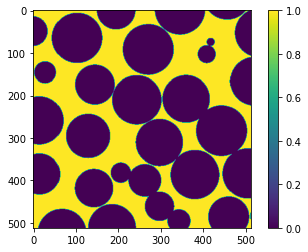

In [4]:
plt.imshow(final_image)
plt.colorbar()

------------------------------------------------------------
Beginning SNOW Algorithm
Converting supplied image (im) to boolean
Peforming Distance Transform
Applying Gaussian blur with sigma = 0.4
Initial number of peaks:  60
Peaks after trimming saddle points:  53
Peaks after trimming nearby peaks:  48


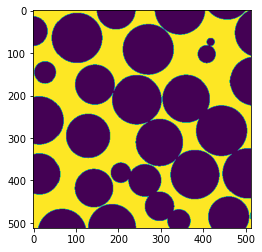

In [5]:

#This identifies all pore (or solid) voxels that are not connected to the edge of the image.
#This can be used to find blind pores, or remove artifacts such as solid phase voxels that are floating in space.

discPoresLoc = ps.filters.find_disconnected_voxels(final_image)

# Trimming blind pores
final_image[discPoresLoc] = False


#plt.imshow(final_image)

#Fills pores not connected to edge of image
filtEdgeIm = ps.filters.fill_blind_pores(final_image)
plt.imshow(filtEdgeIm)


out = ps.filters.snow_partitioning(final_image, return_all=True)
dt = out.dt
im = out.im
peaks = out.peaks
outIM = out.regions


final_image = ps.filters.trim_nearby_peaks(peaks, dt)

# Finds points in a distance transform that are closer to wall than solid.
# These points could potentially be erroneously high since their distance values do not
# reflect the possibility that solid may have been present beyond the border of the image but lost by trimming.
wallDist = ps.filters.find_dt_artifacts(dt)

In [6]:
# This did not work, so working on taking the center of the image
#centerIM = ps.tools.extract_subsection(final_image,[350,350])
#plt.imshow(centerIM)

In [7]:
# See if 350 has trimmed enough
#snow_out = ps.filters.snow_partitioning(centerIM, r_max=4, sigma=0.4, return_all=True)
# snow_out = ps.networks.snow(im)

In [8]:
localThickness = ps.filters.local_thickness(final_image)

localMax = ps.filters.find_peaks(dt)

100%|██████████| 25/25 [00:00<00:00, 70.77it/s]


In [9]:
ps.io.to_openpnm(snow_out,'center_bead.pnm')

NameError: name 'snow_out' is not defined

In [ ]:
pn = op.network.GenericNetwork()
pn.update(snow_out)
prj = pn.project

In [ ]:
waterPhs = op.phases.Water(network=pn, name='waterphs')

geom = op.geometry.GenericGeometry(network=pn,pores=pn.Ps,throats=pn.Ts,name='mainGeom',project=prj)

phys = op.physics.GenericPhysics(network=pn, phase=waterPhs, geometry=geom)

In [ ]:
phys.add_model(propname='throat.entry_pressure',model=op.models.physics.capillary_pressure.washburn)
print(pn.project.grid)

In [ ]:
mip = op.algorithms.OrdinaryPercolation(network=pn,name="perc",project=prj)
mip.set_inlets(pores=pn.pores('left'))
mip.run(points=25,start=None,stop=None)


fig = mip.plot_intrusion_curve()

In [ ]:
prj.export_data(filename='PNM_extraction')

In [ ]:
ps.io.to_vtk(final_image,path='poreSpace2D')

In [ ]:
#lt = ps.filters.local_thickness(final_image, parallel=True)
lt = ps.filters.local_thickness(final_image, parallel=False)
plt.imshow(lt)

In [ ]:
final_image.shape

In [ ]:
porosimIM = ps.filters.porosimetry(final_image)


In [ ]:
#snow_out = ps.filters.snow_partitioning(final_image, r_max=4, sigma=0.4, return_all=True)

In [ ]:
# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[10, 10])
# ax1.imshow(snow_out.im, origin='lower')
# ax2.imshow(snow_out.dt, origin='lower')
# dt_peak = peaks
# peaks_dilated = binary_dilation(peaks > 0)
# dt_peak[peaks_dilated > 0] = np.nan
# cmap = cm.viridis
# cmap.set_bad('red', 1.)
# ax3.imshow(dt_peak, origin='lower', cmap=cmap)
# ax4.imshow(snow_out.regions, origin='lower')
# plt.show()